https://www.kaggle.com/c/competitive-data-science-final-project

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline 

import utility.utility as ut
from preprocessing.createSets import *
from preprocessing.Sets import Sets


########### switches ################################

saveName='Oct15-2018_1'
saveFolder = saveName
saveplots=False
createSubmit = False
if not os.path.exists(saveFolder) and (saveplots or createSubmit): 
    print 'creating folder:',os.getcwd()+'/'+saveFolder
    os.mkdir(saveFolder)
if(saveplots): print "SAVING PLOTS!"
if(createSubmit): print "WILL CREATE SUBMIT FILE!"


############# Options/Args #########################

meanEncode=True
lag_length = 3
diff = True
diffRel = True 
item_cat_count_feat=False

target = 'shop_item_cnt_month'
# target = 'shop_item_cnt_month_diff(0-1)'

meanEncodeCol=[
             'shop',
             'item',
             'item_cat',
            ]

#these columns will be dropped in createTrain/Val/Test
col_targets=[
             'shop_item_cnt_month',
#              'shop_cnt_month',
#              'item_cnt_month',
            ]
if(diff):
    col_targets+[
#                  'shop_item_cnt_month_diff(0-1)',
#                  'shop_cnt_month_diff(0-1)',
#                  'item_cnt_month_diff(0-1)',
                ]
if(diffRel):
    col_targets+[
#                  'shop_item_cnt_month_(0-1)/1',
#                  'shop_cnt_month_(0-1)/1',
#                  'item_cnt_month_(0-1)/1',
                ]

#columns to keep
col_to_keep = [
                'shop_id',
                'item_id',
                #'item_price',
                'item_category_id',
                'item_cnt_day',
              ]

groupby_list = ['shop_id','item_id']

agg_dict = {
            #'item_price':'mean',
            'item_category_id':'mean',
            'item_cnt_day':'sum',
            }

agg_targ = {'item_cnt_day':'sum'} #target_encoding!
# agg_targ = {'item_cnt_day':'mean'} #target_encoding!

    
opt = {
        'lag_length':lag_length,
        'diff':diff,
        'diffRel':diffRel,
        'item_cat_count_feat':item_cat_count_feat,
        'target':target,
        'col_to_keep':col_to_keep,
        'groupby_list':groupby_list,
        'agg_dict':agg_dict,
        'agg_targ':agg_targ,
        'col_targets':col_targets,
        'meanEncode':meanEncode,
        'meanEncodeCol':meanEncodeCol,
        } 


clipTarget = True
lowerClip = 0
upperClip = 20
if target=='shop_item_cnt_month_diff(0-1)':
    lowerClip = -20
    upperClip = 20    

########################################################


# create train/val/test set

In [2]:
Sets = Sets(**opt)

dup_ids = Sets.checkDuplicates()
Sets.convertDatetime()
Sets.addItemCategoryId()
Sets.addYMcolumn()
bin_edges=[0,10,100,200,500,1000,2500,5000,20000,999999]
Sets.binPrice(bin_edges)
Sets.splitDataByYear()
data = Sets.getData()

data['sales_train'].head()


sales_train shape: (2935849, 6)
lag_length: 3
diff: True
diffRel: True
item_cat_count_feat : False
target: shop_item_cnt_month

Checking for duplicates in sales_train

Found 6 duplicates in sales_train : [  76962 1435367 1496766 1671873 1866340 2198566]
Kept first, removed duplicates

Checking for duplicates in test
Found no duplicates in test

Format 'date' to 'datetime' in sales_train

Add new column: 'item_category_id' to sales_train

Add new column: years, month, Y_M to sales_train

Counting based on the defined bins:

0-10 : 36050
10-100 : 121831
100-200 : 501713
200-500 : 1013478
500-1000 : 596653
1000-2500 : 464971
2500-5000 : 167315
5000-20000 : 27050
20000-999999 : 6781
999999-: 0

Adding new column: price_range to sales_train.

Splitting sales_train to sales_train_2013, sales_train_2014, and sales_train_2015.

Retrieving latest (preprocessed) data

sales_train shape: (2935843, 11)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month,Y_M,price_range
1972631,2014-09-01,20,54,0,58.0,1.0,40,2014,9,2014_9,"(10, 100]"
2069405,2014-10-20,21,55,1,4490.0,1.0,76,2014,10,2014_10,"(2500, 5000]"
1552547,2014-04-04,15,55,1,4490.0,1.0,76,2014,4,2014_4,"(2500, 5000]"
1815466,2014-07-06,18,55,1,4490.0,1.0,76,2014,7,2014_7,"(2500, 5000]"
1906676,2014-08-04,19,55,1,4490.0,1.0,76,2014,8,2014_8,"(2500, 5000]"


In [3]:
x_train, y_train = Sets.createTrainSet()
x_val, y_val = Sets.createValSet()
x_test = Sets.createTestSet()

x_train.shape : (51460, 33)
y_train.shape : (51460,)
x_val.shape : (45755, 33)
y_val.shape : (45755,)
x_test.shape : (214200, 25)


# Adding price category to train,val, test

In [4]:
train = data['sales_train']
print 'train.shape:',train.shape

#Aggregate train by 'item_price' and take __minimum__ of price range category

#train['price_range']
train_agg = train.groupby(['item_id'], as_index=False).agg({'price_range':'min'})
#train_agg['price_range']
train_agg[train_agg['price_range'].isna()]

#We're gonna do a hack. Change format to string, fill missing value, then change to 'category'

train_agg['price_range']=train_agg['price_range'].astype('string')
#train_agg['price_range']
train_agg[train_agg['price_range']=='nan']
#train[train['item_id']==2973].groupby(['shop_id','item_id']).agg({'price_range':'min'})
train[train['item_id']==2973]['price_range'].unique()

#It seems all of item 2973 are priced (1000,2500], let go ahead and fix the missing value

train_agg.at[2913,'price_range']='(1000,2500]'
train_agg['price_range']=train_agg['price_range'].astype('category')
#train_agg['price_range']
train_agg[train_agg['price_range'].isna()]
train_agg[train_agg.index==2913]

#ok, we've fixed that missing value for train_agg. Now merge with x_train

print 'x_train.shape, train_agg.shape:',x_train.shape, train_agg.shape
x_train = pd.merge(x_train,train_agg[['item_id','price_range']],on='item_id',how='left')
print 'x_train.shape',x_train.shape
x_train[x_train['price_range'].isna()]
x_val = pd.merge(x_val,train_agg[['item_id','price_range']],on='item_id',how='left')
print 'x_val.shape',x_val.shape
x_val[x_val['price_range'].isna()]
x_test.shape
x_test = pd.merge(x_test,train_agg[['item_id','price_range']],on='item_id',how='left')
print  'fraction rows with NaN price range in x_test:',1.0*x_test[x_test['price_range'].isna()].shape[0] / x_test.shape[0] 

train.shape: (2935843, 11)
x_train.shape, train_agg.shape: (51460, 33) (21807, 2)
x_train.shape (51460, 34)
x_val.shape (45755, 34)
fraction rows with NaN price range in x_test: 0.0711764705882


Two choices: 1. Ignore these small unkowns, let the BDT do its best with other known features. 2. Lets predict these new items with the average sales count from the month before, as the best case scenario.

In [5]:
x_test.head()

,shop_id,item_id,item_category_id,shop_item_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,shop_item_cnt_month_lag_2,shop_cnt_month_lag_2,item_cnt_month_lag_2,...,shop_item_cnt_month_lag_3,shop_cnt_month_lag_3,item_cnt_month_lag_3,shop_item_cnt_month_diff(2-3),shop_item_cnt_month_(2-3)/3,shop_cnt_month_diff(2-3),shop_cnt_month_(2-3)/3,item_cnt_month_diff(2-3),item_cnt_month_(2-3)/3,price_range
0,2,30,40,2_30,0.0,727.0,1.0,0.0,822.0,3.0,...,0.0,942.0,6.0,0.0,0.0,-120.0,-0.127389,-3.0,-0.500000,"(10, 100]"
1,2,31,37,2_31,1.0,727.0,18.0,0.0,822.0,9.0,...,0.0,942.0,53.0,0.0,0.0,-120.0,-0.127389,-44.0,-0.830189,"(100, 200]"
2,2,32,40,2_32,0.0,727.0,22.0,0.0,822.0,19.0,...,1.0,942.0,30.0,0.0,0.0,-120.0,-0.127389,-11.0,-0.366667,"(10, 100]"
3,2,33,37,2_33,0.0,727.0,16.0,1.0,822.0,16.0,...,0.0,942.0,14.0,0.0,0.0,-120.0,-0.127389,2.0,0.142857,"(100, 200]"
4,2,38,41,2_38,0.0,727.0,0.0,0.0,822.0,2.0,...,0.0,942.0,7.0,0.0,0.0,-120.0,-0.127389,-5.0,-0.714286,"(1000, 2500]"


In [6]:
#combine 2013+2014
# x_train  = pd.concat([x_train, x_val], ignore_index=True)
# y_train  = pd.concat([y_train, y_val], ignore_index=True)
# print x_train.shape

# Clip y_train, y_val

In [7]:
nbins=20

# hist_y_train = plt.hist(y_train,nbins,log=True)
y_train_clip = np.clip(y_train,lowerClip,upperClip)
# hist_y_train_clip = plt.hist(y_train_clip,nbins,log=True)
# his_y_val = plt.hist(y_val,nbins,log=True)
y_val_clip = np.clip(y_val,lowerClip,upperClip)
# his_y_val_clip = plt.hist(y_val_clip,nbins,log=True)
print 'Sum y_train before clip:',np.sum(y_train)
print 'Sum y_val before clip:', np.sum(y_val)
if(clipTarget):
    y_train=y_train_clip
    y_val=y_val_clip
print 'Sum y_train after clip:',np.sum(y_train)
print 'Sum y_val after clip:', np.sum(y_val)

Sum y_train before clip: 130009.0
Sum y_val before clip: 117845.0
Sum y_train after clip: 110388.0
Sum y_val after clip: 98404.0


# Target encode with KFold reg

In [8]:
df = pd.merge(x_train,y_train.to_frame(),left_index=True,right_index=True,how='left')

df.head()

,shop_id,item_id,item_category_id,shop_item_id,shop_cnt_month,item_cnt_month,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,shop_item_cnt_month_diff(0-1),...,shop_cnt_month_lag_3,item_cnt_month_lag_3,shop_item_cnt_month_diff(2-3),shop_item_cnt_month_(2-3)/3,shop_cnt_month_diff(2-3),shop_cnt_month_(2-3)/3,item_cnt_month_diff(2-3),item_cnt_month_(2-3)/3,price_range,shop_item_cnt_month
0,2,33,37,2_33,862.0,15.0,0.0,795.0,33.0,0.0,...,875.0,35.0,0.0,0.0,70.0,0.08,8.0,0.228571,"(100, 200]",2.0
1,2,97,40,2_97,862.0,2.0,0.0,795.0,4.0,0.0,...,875.0,11.0,0.0,0.0,70.0,0.08,-4.0,-0.363636,"(10, 100]",1.0
2,2,482,73,2_482,862.0,85.0,1.0,795.0,132.0,1.0,...,875.0,64.0,0.0,0.0,70.0,0.08,28.0,0.437500,"(1000, 2500]",2.0
3,2,791,73,2_791,862.0,42.0,2.0,795.0,62.0,-1.0,...,875.0,46.0,2.0,2.0,70.0,0.08,2.0,0.043478,"(200, 500]",1.0
4,2,944,37,2_944,862.0,22.0,0.0,795.0,40.0,0.0,...,875.0,36.0,0.0,0.0,70.0,0.08,0.0,0.000000,"(10, 100]",1.0


In [9]:
from sklearn.model_selection import KFold
kf = KFold(5,shuffle=True,random_state=1234)

targEnc_to_Reg = {
#                     'shop_id':'shop',
#                     'item_id':'item',
#                     'item_category_id':'item_cat',
#                     'price_range':'price_range'
                    }

NaN_targEnc = {
#                 'shop':-999,
#                 'item':-999,
#                 'item_cat':-999,
#                 'price_range':-999,
                }

#introduce price_range target encoding: price_range_cnt_month
df_temp=df.groupby('price_range',as_index=False).agg({'shop_item_cnt_month':'sum'}).rename(columns={'shop_item_cnt_month':'price_range_cnt_month'})
df = pd.merge(df,df_temp,on='price_range',how='left')


for key,value in targEnc_to_Reg.items():
    #initialize
    df[value+'_cnt_month_kFold'] = df[value+'_cnt_month']

    #let's use median of the mean (per feat) for global stat for replacing NaN. can experiment later using min, mean, etc.
    replaceNaN = df.groupby(key)[value+'_cnt_month'].mean().median()
    NaN_targEnc.update({value:replaceNaN})
    for tr_ind,val_ind in kf.split(df):
        df_tr, df_val = df.iloc[tr_ind],df.iloc[val_ind]
        feat_target_sum = df_tr.groupby(key)['shop_item_cnt_month'].sum()
        df_val[value+'_cnt_month_kFold'] = df_val[key].map(feat_target_sum)  
        df_val[value+'_cnt_month_kFold'].fillna(replaceNaN, inplace=True)
        df.at[val_ind,value+'_cnt_month_kFold'] = df_val[value+'_cnt_month_kFold'] 

print 'To replace NaN we use the median of the mean',NaN_targEnc

To replace NaN we use the median of the mean {}


In [10]:
col_temp = [x+'_cnt_month' for x in targEnc_to_Reg.values()]
col_temp += [x+'_cnt_month_kFold' for x in targEnc_to_Reg.values()]
x_train = df
print x_train.shape
x_train[col_temp].head()

(51460, 36)


""
0
1
2
3
4


In [11]:
# map encoding to x_val

#add target back
# df = pd.merge(x_val,y_val.to_frame(),left_index=True,right_index=True,how='left')
# df.head()

#introduce price_range target encoding: price_range_cnt_month
# df_temp=df.groupby('price_range',as_index=False).agg({'shop_item_cnt_month':'sum'}).rename(columns={'shop_item_cnt_month':'price_range_cnt_month'})
# df = pd.merge(df,df_temp,on='price_range',how='left')
# df.head()

# map x_train targ_enc_kFol to x_val
df = x_val
for key,value in targEnc_to_Reg.items():
    print 'adding:',value
    df_temp = x_train.groupby(key)[value+'_cnt_month_kFold'].mean()
    df_temp = df[key].map(df_temp)
    df[value+'_cnt_month_kFold'] = df_temp
    df[value+'_cnt_month_kFold'].fillna(NaN_targEnc[value], inplace=True)    

In [12]:
df.head()

,shop_id,item_id,item_category_id,shop_item_id,shop_cnt_month,item_cnt_month,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,shop_item_cnt_month_diff(0-1),...,shop_item_cnt_month_lag_3,shop_cnt_month_lag_3,item_cnt_month_lag_3,shop_item_cnt_month_diff(2-3),shop_item_cnt_month_(2-3)/3,shop_cnt_month_diff(2-3),shop_cnt_month_(2-3)/3,item_cnt_month_diff(2-3),item_cnt_month_(2-3)/3,price_range
0,2,486,73,2_486,1192.0,170.0,1.0,945.0,183.0,1.0,...,0.0,956.0,0.0,0.0,0.0,-36.0,-0.037657,0.0,0.000000,"(100, 200]"
1,2,491,73,2_491,1192.0,17.0,1.0,945.0,18.0,0.0,...,0.0,956.0,30.0,0.0,0.0,-36.0,-0.037657,-16.0,-0.533333,"(200, 500]"
2,2,806,49,2_806,1192.0,54.0,1.0,945.0,63.0,0.0,...,2.0,956.0,50.0,12.0,6.0,-36.0,-0.037657,14.0,0.280000,"(100, 200]"
3,2,949,23,2_949,1192.0,31.0,0.0,945.0,35.0,0.0,...,3.0,956.0,43.0,0.0,0.0,-36.0,-0.037657,-22.0,-0.511628,"(200, 500]"
4,2,950,19,2_950,1192.0,17.0,0.0,945.0,27.0,0.0,...,3.0,956.0,23.0,0.0,0.0,-36.0,-0.037657,4.0,0.173913,"(200, 500]"


In [13]:
#col_temp = [x+'_cnt_month' for x in targEnc_to_Reg.values()]
col_temp = [x+'_cnt_month_kFold' for x in targEnc_to_Reg.values()]
x_val = df
print x_val.shape
x_val[col_temp].head()

(45755, 34)


""
0
1
2
3
4


In [14]:
# map x_train targ_enc_kFol to x_test
df = x_test
for key,value in targEnc_to_Reg.items():
    print 'adding:',value
    df_temp = x_train.groupby(key)[value+'_cnt_month_kFold'].mean()
    df_temp = df[key].map(df_temp)
    df[value+'_cnt_month_kFold'] = df_temp
    df[value+'_cnt_month_kFold'].fillna(NaN_targEnc[value], inplace=True)    
df.head()

,shop_id,item_id,item_category_id,shop_item_id,shop_item_cnt_month_lag_1,shop_cnt_month_lag_1,item_cnt_month_lag_1,shop_item_cnt_month_lag_2,shop_cnt_month_lag_2,item_cnt_month_lag_2,...,shop_item_cnt_month_lag_3,shop_cnt_month_lag_3,item_cnt_month_lag_3,shop_item_cnt_month_diff(2-3),shop_item_cnt_month_(2-3)/3,shop_cnt_month_diff(2-3),shop_cnt_month_(2-3)/3,item_cnt_month_diff(2-3),item_cnt_month_(2-3)/3,price_range
0,2,30,40,2_30,0.0,727.0,1.0,0.0,822.0,3.0,...,0.0,942.0,6.0,0.0,0.0,-120.0,-0.127389,-3.0,-0.500000,"(10, 100]"
1,2,31,37,2_31,1.0,727.0,18.0,0.0,822.0,9.0,...,0.0,942.0,53.0,0.0,0.0,-120.0,-0.127389,-44.0,-0.830189,"(100, 200]"
2,2,32,40,2_32,0.0,727.0,22.0,0.0,822.0,19.0,...,1.0,942.0,30.0,0.0,0.0,-120.0,-0.127389,-11.0,-0.366667,"(10, 100]"
3,2,33,37,2_33,0.0,727.0,16.0,1.0,822.0,16.0,...,0.0,942.0,14.0,0.0,0.0,-120.0,-0.127389,2.0,0.142857,"(100, 200]"
4,2,38,41,2_38,0.0,727.0,0.0,0.0,822.0,2.0,...,0.0,942.0,7.0,0.0,0.0,-120.0,-0.127389,-5.0,-0.714286,"(1000, 2500]"


In [15]:
#col_temp = [x+'_cnt_month' for x in targEnc_to_Reg.values()]
col_temp = [x+'_cnt_month_kFold' for x in targEnc_to_Reg.values()]
x_test = df
x_test[col_temp].head()

""
0
1
2
3
4


In [16]:
x_train_ = x_train.drop(columns=['shop_item_id'])
x_val_ = x_val.drop(columns=['shop_item_id'])
x_test_ = x_test.drop(columns=['shop_item_id'])

In [17]:
print x_train_.shape
print x_val_.shape
print x_test_.shape 
# print 'train:',x_train_.columns.values
# print 'test:',x_test_.columns.values
print 'train-test:',set(x_train_.columns.values)-set(x_test_.columns.values)
print 'val-test:',set(x_val_.columns.values)-set(x_test_.columns.values)

(51460, 35)
(45755, 33)
(214200, 25)
train-test: set(['shop_cnt_month', 'shop_item_cnt_month', 'item_cnt_month_diff(0-1)', 'price_range_cnt_month', 'item_cnt_month', 'item_cnt_month_(0-1)/1', 'shop_item_cnt_month_(0-1)/1', 'shop_item_cnt_month_diff(0-1)', 'shop_cnt_month_diff(0-1)', 'shop_cnt_month_(0-1)/1'])
val-test: set(['shop_cnt_month', 'item_cnt_month_(0-1)/1', 'item_cnt_month_diff(0-1)', 'item_cnt_month', 'shop_item_cnt_month_(0-1)/1', 'shop_item_cnt_month_diff(0-1)', 'shop_cnt_month_diff(0-1)', 'shop_cnt_month_(0-1)/1'])


In [18]:
x_train_ = x_train_.drop(columns=list(set(x_train_.columns.values)-set(x_test_.columns.values)))
x_val_ = x_val_.drop(columns=list(set(x_val_.columns.values)-set(x_test_.columns.values)))

In [19]:
print x_train_.shape
print x_val_.shape
print x_test_.shape 
print 'train:',x_train_.columns.values
print 'test:',x_test_.columns.values
print 'train-test:',set(x_train_.columns.values)-set(x_test_.columns.values)
print 'val-test:',set(x_val_.columns.values)-set(x_test_.columns.values)

(51460, 25)
(45755, 25)
(214200, 25)
train: ['shop_id' 'item_id' 'item_category_id' 'shop_item_cnt_month_lag_1'
 'shop_cnt_month_lag_1' 'item_cnt_month_lag_1' 'shop_item_cnt_month_lag_2'
 'shop_cnt_month_lag_2' 'item_cnt_month_lag_2'
 'shop_item_cnt_month_diff(1-2)' 'shop_item_cnt_month_(1-2)/2'
 'shop_cnt_month_diff(1-2)' 'shop_cnt_month_(1-2)/2'
 'item_cnt_month_diff(1-2)' 'item_cnt_month_(1-2)/2'
 'shop_item_cnt_month_lag_3' 'shop_cnt_month_lag_3' 'item_cnt_month_lag_3'
 'shop_item_cnt_month_diff(2-3)' 'shop_item_cnt_month_(2-3)/3'
 'shop_cnt_month_diff(2-3)' 'shop_cnt_month_(2-3)/3'
 'item_cnt_month_diff(2-3)' 'item_cnt_month_(2-3)/3' 'price_range']
test: ['shop_id' 'item_id' 'item_category_id' 'shop_item_cnt_month_lag_1'
 'shop_cnt_month_lag_1' 'item_cnt_month_lag_1' 'shop_item_cnt_month_lag_2'
 'shop_cnt_month_lag_2' 'item_cnt_month_lag_2'
 'shop_item_cnt_month_diff(1-2)' 'shop_item_cnt_month_(1-2)/2'
 'shop_cnt_month_diff(1-2)' 'shop_cnt_month_(1-2)/2'
 'item_cnt_month_diff(1-2)

# Model Training

In [20]:
### Boosted Decision Tree (lightgbm)

import lightgbm as lgb
from sklearn.metrics import r2_score

evals_result={}

lgb_train = lgb.Dataset(x_train_, label=y_train)
lgb_test = lgb.Dataset(x_val_, label=y_val)

lgb_params = {
               'feature_fraction': .75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75,#0.75 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
              }

num_boost_round = 1000
verbose_eval = num_boost_round/20
model = lgb.train(lgb_params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_test],
                  valid_names=['train','eval'],
                  num_boost_round=num_boost_round,
                  evals_result=evals_result,
                  early_stopping_rounds=200,
                  verbose_eval=verbose_eval)

#print 'evals_result = ',evals_result

/anaconda2/lib/python2.7/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[50]	train's rmse: 1.96768	eval's rmse: 2.22671
[100]	train's rmse: 1.74844	eval's rmse: 2.16562
[150]	train's rmse: 1.63909	eval's rmse: 2.16733
[200]	train's rmse: 1.56688	eval's rmse: 2.16982
[250]	train's rmse: 1.51901	eval's rmse: 2.17753
[300]	train's rmse: 1.47833	eval's rmse: 2.1905
[350]	train's rmse: 1.44512	eval's rmse: 2.19512
Early stopping, best iteration is:
[163]	train's rmse: 1.61797	eval's rmse: 2.1626


Plot metrics recorded during training...
Plot feature importances...


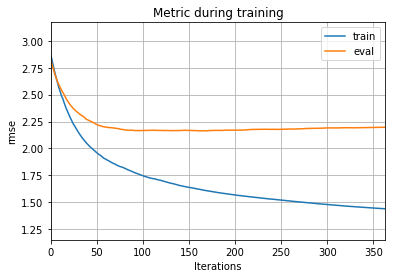

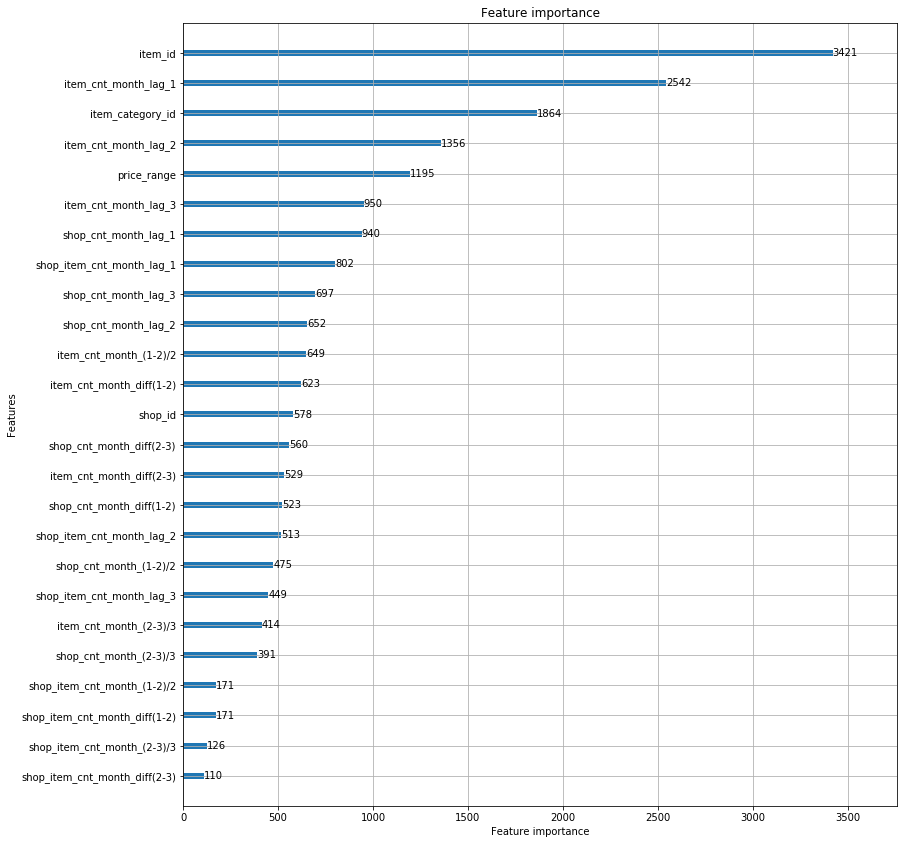

In [21]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_metric_"+saveName+".pdf")
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=x_test.shape[1])
ax.figure.set_size_inches(6.4*2,4.8*3)
if(saveplots):plt.savefig(saveFolder+"/"+"lgb_plot_importance_"+saveName+".pdf")
plt.show()

In [22]:
pred_lgb = model.predict(x_train_)
print('Training R-squared for LightGBM is %f' % r2_score(y_train, pred_lgb))
pred_lgb = model.predict(x_val_)
print('Validation R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Training R-squared for LightGBM is 0.694383
Validation R-squared for LightGBM is 0.428779


# Predict with test data¶

In [23]:
pred = model.predict(x_test_)

In [24]:
print pred.size
print pred
print 'Sum pred:',np.sum(pred)
pred_submit = pred

214200
[1.09931233 1.41221034 1.30181945 ... 1.09712128 1.08891656 1.18649424]
Sum pred: 282160.4055147255


In [25]:
#translate back to shop_item_cnt_month in needed
if target =='shop_item_cnt_month_diff(0-1)':  
    last_month_shop_item_cnt_month = sales_2015[sales_2015['month']==(10)].groupby(groupby_list,as_index=False).agg(agg_dict).rename(columns={'item_cnt_day':'shop_item_cnt_month_lag_1'})
    last_month_shop_item_cnt_month = last_month_shop_item_cnt_month[['shop_id','item_id','shop_item_cnt_month_lag_1']].head()
    df_temp = pd.merge(x_test[['shop_id','item_id']],last_month_shop_item_cnt_month,on=('shop_id','item_id'),how='left')
    df_temp.fillna(0,inplace=True)
    df_temp.head()

    df_pred = pd.DataFrame(pred,columns=['y_pred_residual'])
    df_pred.head()

    df_pred['y_pred'] = df_temp['shop_item_cnt_month_lag_1'] + df_pred['y_pred_residual']
    df_pred.head()

    pred_submit = df_pred['y_pred'].values
    
# True target values are clipped into [0,20] range.
pred_submit = np.clip(pred_submit,0,20)
    
print pred_submit


[1.09931233 1.41221034 1.30181945 ... 1.09712128 1.08891656 1.18649424]


total sales pred: 282189.7122500439 , mean: 1.317412288749038


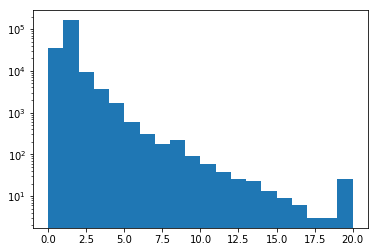

In [26]:
print 'total sales pred:',np.sum(pred_submit), ', mean:',np.mean(pred_submit)
hist_pred = plt.hist(pred_submit,nbins,log=True)

In [27]:
### adhoc scaling
#pred_submit = np.floor(pred_submit)
#pred_submit = (pred_submit)*0.25 
# print 'total sales pred:',np.sum(pred_submit),', mean:',np.mean(pred_submit)
# hist_pred = plt.hist(pred_submit,nbins,log=True)
# print pred_submit

In [28]:
## adhoc scaling v2
#pred_submit = (pred_submit)*x_train.shape[0]/x_test.shape[0]
# print 'total sales pred:',np.sum(pred_submit),', mean:',np.mean(pred_submit)
# hist_pred = plt.hist(pred_submit,nbins,log=True)
# print pred_submit

# Validation with yearly trend

total sales count from Oct15-2018_1 prediction: 282189.7122500439
total sales count from contant 0.5 prediction: 107100.0


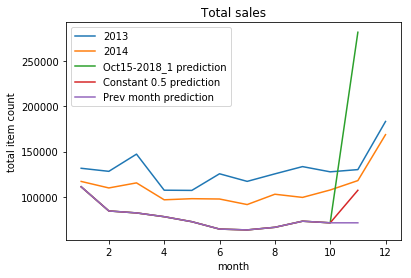

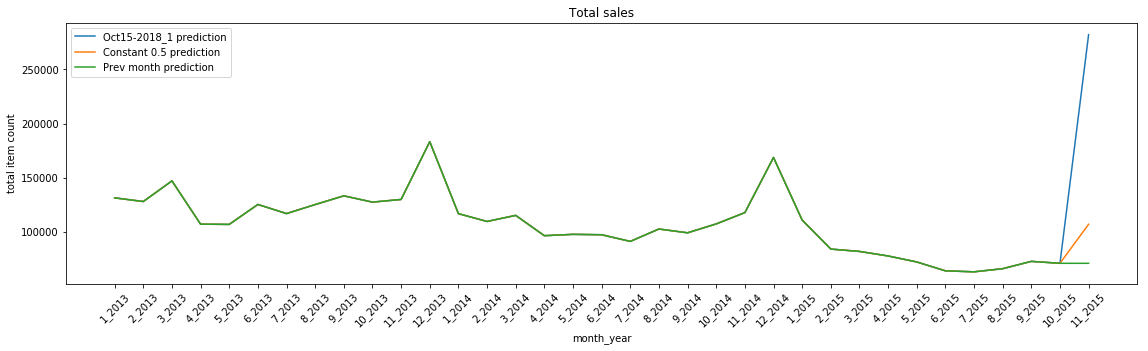

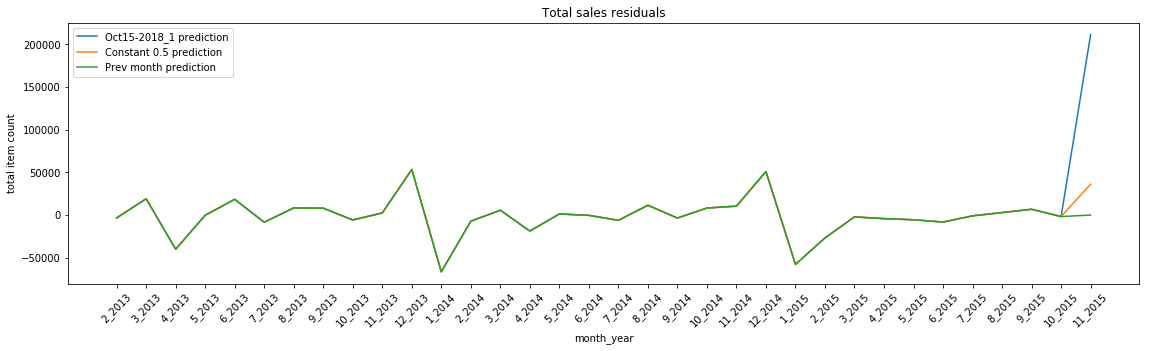

In [29]:
y_test = pd.DataFrame(pred_submit,columns=['item_cnt_month'])
#saveName='constant_0p38'
#saveplots=True

total_item_cnt_2013 = data['sales_2013'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2014 = data['sales_2014'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
total_item_cnt_2015 = data['sales_2015'].groupby(['date_block_num','Y_M'])['item_cnt_day'].sum().values
yearlySales = [total_item_cnt_2013,total_item_cnt_2014,total_item_cnt_2015]

kwargs = {'yearlySales':yearlySales,
        'y_test':y_test,
        'saveName':saveName,
        'saveplots':saveplots,
        'saveFolder':saveFolder}

ut.plotYearly(**kwargs)
ut.plotYearly_v2(**kwargs)
ut.plotResidual(**kwargs)

# Prepare submission file

In [30]:
test_sorted = data['test'].sort_values(by=groupby_list).reset_index(drop=True)
submit = pd.concat([test_sorted,y_test],axis=1)
submit = submit.sort_values(by="ID").reset_index(drop=True)

# sanity check
print 'These numbers below should match:'
print 'y_test.iloc[0] =',y_test.iloc[0].values[0] 
print 'submit[submit["ID"]==22987] = ',submit[submit["ID"]==22987]["item_cnt_month"].values[0]

submit = submit[["item_cnt_month"]]
submit.index.name="ID"
submit.head()

submitName=''
if submitName=='': 
    submitName=saveName
if(createSubmit):submit.to_csv('submit_'+submitName+'.csv')

These numbers below should match:
y_test.iloc[0] = 1.0993123291390874
submit[submit["ID"]==22987] =  1.0993123291390874
